# Compute distance and geodesic between meshes

This notebook shows how `geomstats` can be used to compute distances and geodesics between already-registered meshes using an elastic metric.

It downloads meshes from [figshare](https://figshare.com/articles/dataset/pregnancy-data/28339535), uses [pyvista](https://docs.pyvista.org/) for visualization, and [geomstats](https://geomstats.github.io/) for computing distances and geodesics.

In [1]:
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"

In [2]:
import pyvista as pv

import geomstats.backend as gs
from geomstats.geometry.discrete_surfaces import DiscreteSurfaces, ElasticMetric

from polpo.preprocessing import Map
from polpo.preprocessing.load.pregnancy import PregnancyPilotRegisteredMeshesLoader
from polpo.preprocessing.mesh.io import PvReader
from polpo.preprocessing.mesh.conversion import DataFromPv, PvFromData

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [3]:
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

Let's download some already-registered mesh data (see e.g. [this](https://geometric-intelligence.github.io/polpo/_notebooks/how_to/mesh/mesh_viz_compare.html) for more details.)

In [4]:
loader = PregnancyPilotRegisteredMeshesLoader(
    subset=[1, 2], method="elastic", version=0
) + Map(PvReader())

tensors_from_pv = Map(
    step=DataFromPv(keep_colors=False) + Map(gs.from_numpy), force_iter=True
)
pv_from_tensors = Map(step=Map(gs.to_numpy) + PvFromData(), force_iter=True)

In [5]:
registered_pvmeshes = loader()

registered_meshes = tensors_from_pv(registered_pvmeshes)

INFO: Data has already been downloaded... using cached file ('/home/luisfpereira/.herbrain/data/pregnancy/registration/elastic_0').


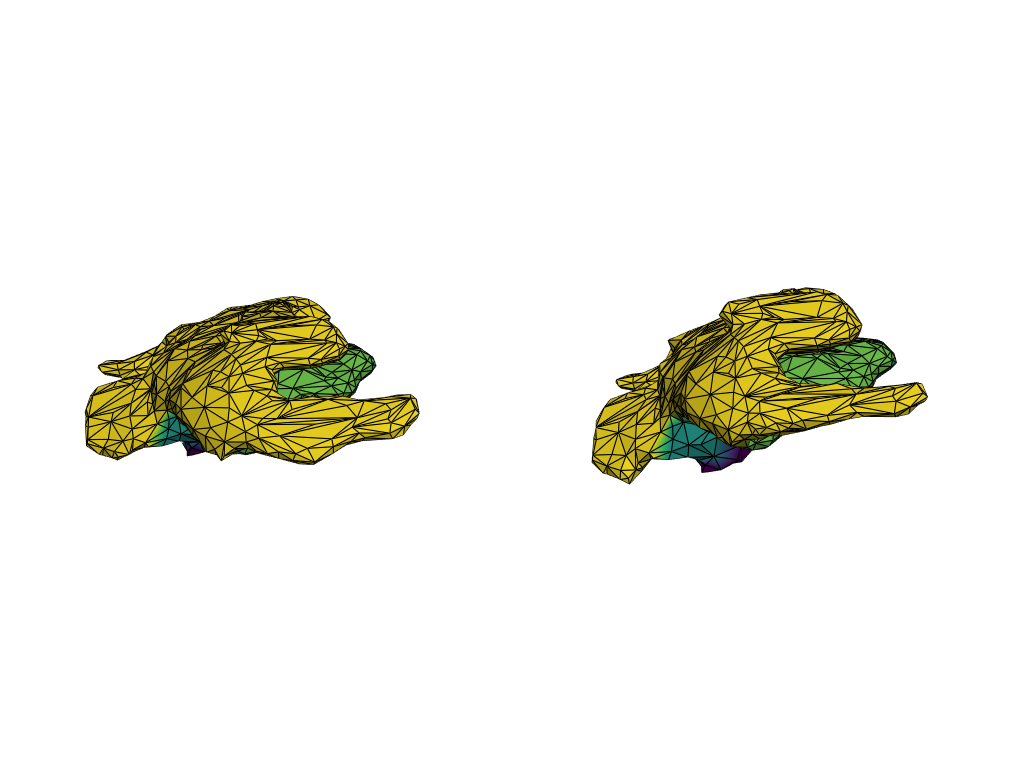

In [6]:
pl = pv.Plotter(shape=(1, 2), border=False)

pl.subplot(0, 0)
pl.add_mesh(registered_pvmeshes[0], show_edges=True)
pl.remove_scalar_bar()

pl.subplot(0, 1)
pl.add_mesh(registered_pvmeshes[1], show_edges=True)
pl.remove_scalar_bar()

pl.show()

Compute distances between meshes.

In [7]:
faces = registered_meshes[0][1]
vertices = gs.stack([mesh[0] for mesh in registered_meshes])

In [8]:
space = DiscreteSurfaces(faces, equip=False).equip_with_metric(
    ElasticMetric,
    a0=0.01,
    a1=10.0,
    b1=10.0,
    c1=1.0,
    d1=0.0,
    a2=1.0,
)

In [9]:
space.metric.squared_dist(vertices[0], vertices[1])

tensor(718.2803)

Compute and plot geodesics.

In [10]:
geod = space.metric.geodesic(vertices[0], end_point=vertices[1])

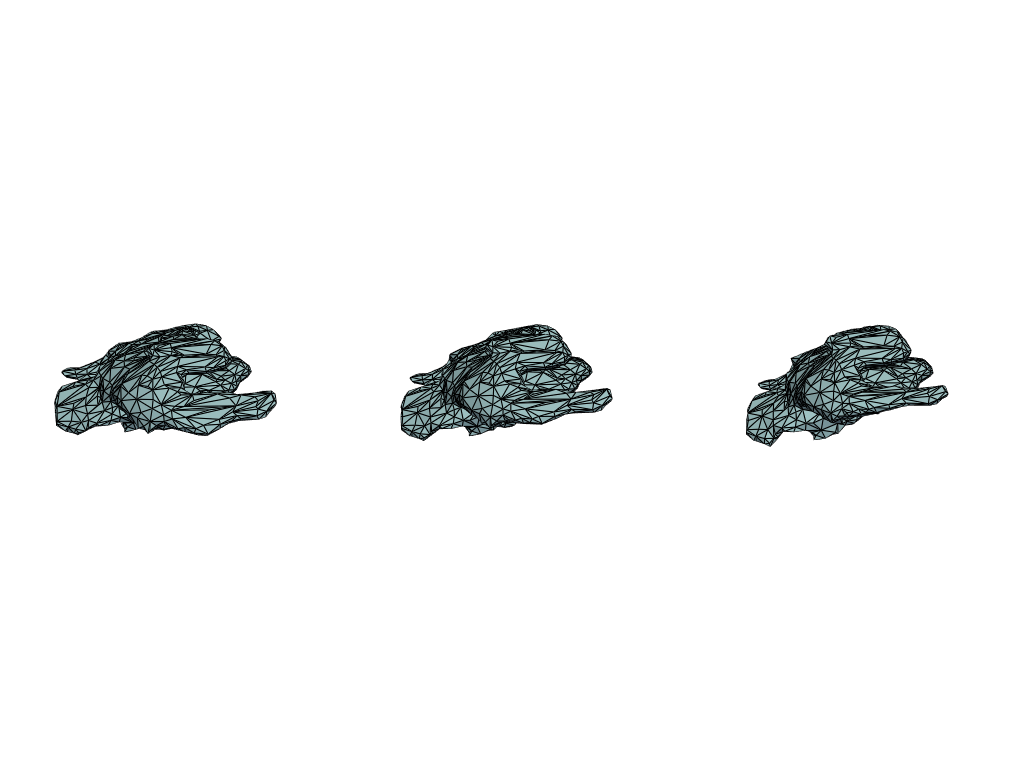

In [11]:
pl = pv.Plotter(shape=(1, 3), border=False)

pl.subplot(0, 0)
pl.add_mesh(pv_from_tensors((geod(0.0)[0], faces)), show_edges=True)

pl.subplot(0, 1)
pl.add_mesh(pv_from_tensors((geod(0.5)[0], faces)), show_edges=True)

pl.subplot(0, 2)
pl.add_mesh(pv_from_tensors((geod(1.0)[0], faces)), show_edges=True)

pl.link_views()

pl.show()